In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (img_size // 8) * (img_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * (img_size // 8) * (img_size // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (256, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

# Dataset wrapper to add synthetic samples
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, class_counts, autoencoder, latent_dim, img_size, num_synthetic_per_class, threshold, transform=None):
        self.original_dataset = original_dataset
        self.class_counts = class_counts
        self.autoencoder = autoencoder
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_synthetic_per_class = num_synthetic_per_class
        self.threshold = threshold
        self.transform = transform

        # Split classes into overrepresented and underrepresented
        self.underrepresented_classes = [
            label for label, count in class_counts.items() if count <= threshold
        ]
        self.synthetic_samples = self.generate_synthetic_samples()

    def generate_synthetic_samples(self):
        synthetic_samples = []
        self.autoencoder.eval()
        with torch.no_grad():
            for class_label in self.underrepresented_classes:
                # Get all images of the current class
                class_images = [
                    img for idx, (img, label) in enumerate(self.original_dataset)
                    if label == class_label
                ]

                # Encode and perturb latent vectors
                for _ in range(self.num_synthetic_per_class):
                    # Randomly select an image from the class
                    img = transforms.ToTensor()(class_images[torch.randint(len(class_images), (1,)).item()])
                    img = transforms.Resize((self.img_size, self.img_size))(img).unsqueeze(0).to(device)
                    latent_vector = self.autoencoder.encoder(img)

                    # Apply small random perturbations
                    perturbed_latent = latent_vector + torch.randn_like(latent_vector) * 0.1

                    # Decode the perturbed latent vector
                    synthetic_image = self.autoencoder.decoder(perturbed_latent).squeeze(0).cpu()
                    synthetic_samples.append((synthetic_image, class_label))

        return synthetic_samples

    def __len__(self):
        return len(self.original_dataset) + len(self.synthetic_samples)

    def __getitem__(self, index):
        if index < len(self.original_dataset):
            img, label = self.original_dataset[index]
            if self.transform:
                img = self.transform(img)  # Apply transformation
            img = img.to(device)
            label = torch.tensor(label, dtype=torch.long).to(device)  # Ensure label is a Tensor
        else:
            img, label = self.synthetic_samples[index - len(self.original_dataset)]
            img = img.to(device)
            label = torch.tensor(label, dtype=torch.long).to(device)  # Ensure label is a Tensor

        return img, label

# Define transformations (resize, ToTensor, Normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Everything else remains the same as your provided code
# Initialize the autoencoder model
latent_dim = 100
img_size = 224
autoencoder = Autoencoder(latent_dim, img_size).to(device)

# Load training dataset
train_dataset = ImageFolder(root='train')

# Get class counts for training dataset
class_countsT = {label: len([f for f in train_dataset.targets if f == label]) for label in set(train_dataset.targets)}

# Define threshold and number of synthetic samples to generate
threshold_train = 25
num_synthetic_per_class = 400

# Create augmented training dataset
augmented_train_dataset = AugmentedDataset(
    train_dataset,
    class_countsT,
    autoencoder,
    latent_dim,
    img_size,
    num_synthetic_per_class,
    threshold_train,
    transform
)

# Use DataLoader for training
train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)

print(f"Augmented training dataset size: {len(augmented_train_dataset)}")

# Load validation dataset (no augmentation applied here, just ToTensor & Normalize)
val_dataset = ImageFolder(root='val')

# Get class counts for validation dataset
class_countsV = {label: len([f for f in val_dataset.targets if f == label]) for label in set(val_dataset.targets)}
threshold_val = 11
num_synthetic_per_class_val = 80

# Create augmented validation dataset
augmented_val_dataset = AugmentedDataset(
    val_dataset,
    class_countsV,
    autoencoder,
    latent_dim,
    img_size,
    num_synthetic_per_class_val,
    threshold_val,
    transform
)

# Use DataLoader for validation
val_loader = DataLoader(augmented_val_dataset, batch_size=64, shuffle=False)

print(f"Augmented val dataset size: {len(augmented_val_dataset)}")


Device: cuda
Augmented training dataset size: 5216
Augmented val dataset size: 1274


In [2]:
# Load pretrained EfficientNet-B3
model = models.efficientnet_b3(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():  # Classifier
    param.requires_grad = True

num_ftrs = model.classifier[1].in_features  
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 18)  
)

for param in model.features[-5].parameters():  
    param.requires_grad = True

model = model.to(device)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:

# Define optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [4]:
# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Store labels and predictions for reporting
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    # Classification report (optional)
    #if not model.training:
        #print("\nClassification Report:")
        #print(classification_report(all_labels, all_predictions, target_names=val_dataset.classes))

    return epoch_loss, epoch_acc

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/15
Train Loss: 2.1781, Train Acc: 0.2676
Val Loss: 1.8602, Val Acc: 0.3587

Epoch 2/15
Train Loss: 1.7347, Train Acc: 0.3840
Val Loss: 1.6580, Val Acc: 0.4082

Epoch 3/15
Train Loss: 1.5085, Train Acc: 0.4607
Val Loss: 1.6266, Val Acc: 0.4490

Epoch 4/15
Train Loss: 1.3620, Train Acc: 0.5063
Val Loss: 1.5291, Val Acc: 0.4631

Epoch 5/15
Train Loss: 1.2222, Train Acc: 0.5497
Val Loss: 2.5635, Val Acc: 0.4537

Epoch 6/15
Train Loss: 1.0307, Train Acc: 0.6229
Val Loss: 1.4852, Val Acc: 0.4765

Epoch 7/15
Train Loss: 0.9511, Train Acc: 0.6488
Val Loss: 1.5028, Val Acc: 0.4765

Epoch 8/15
Train Loss: 0.9034, Train Acc: 0.6710
Val Loss: 1.5033, Val Acc: 0.4827

Epoch 9/15
Train Loss: 0.8708, Train Acc: 0.6745
Val Loss: 1.5143, Val Acc: 0.4780

Epoch 10/15
Train Loss: 0.8463, Train Acc: 0.6802
Val Loss: 1.5137, Val Acc: 0.4765

Epoch 11/15
Train Loss: 0.8142, Train Acc: 0.7023
Val Loss: 1.5201, Val Acc: 0.4655

Epoch 12/15
Train Loss: 0.8183, Train Acc: 0.6971
Val Loss: 1.5314, Val A


Classification Report:
                precision    recall  f1-score   support

     AmorfHead       0.38      0.44      0.41       215
AsymmetricNeck       0.00      0.00      0.00        22
     CurlyTail       0.76      0.74      0.75        87
    DoubleHead       0.47      0.66      0.55        83
    DoubleTail       0.57      0.33      0.42        12
      LongTail       0.39      0.20      0.27        83
NarrowAcrosome       0.54      0.64      0.58       124
        Normal       0.70      0.78      0.74        36
       PinHead       0.96      0.98      0.97        47
  PyriformHead       0.24      0.20      0.22        59
      RounHead       0.00      0.00      0.00        16
     ShortTail       0.46      0.40      0.43        60
   TaperedHead       0.36      0.29      0.32        84
     ThickNeck       0.39      0.45      0.42       119
      ThinNeck       0.00      0.00      0.00        12
   TwistedNeck       0.49      0.46      0.47        70
   TwistedTail       0.

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

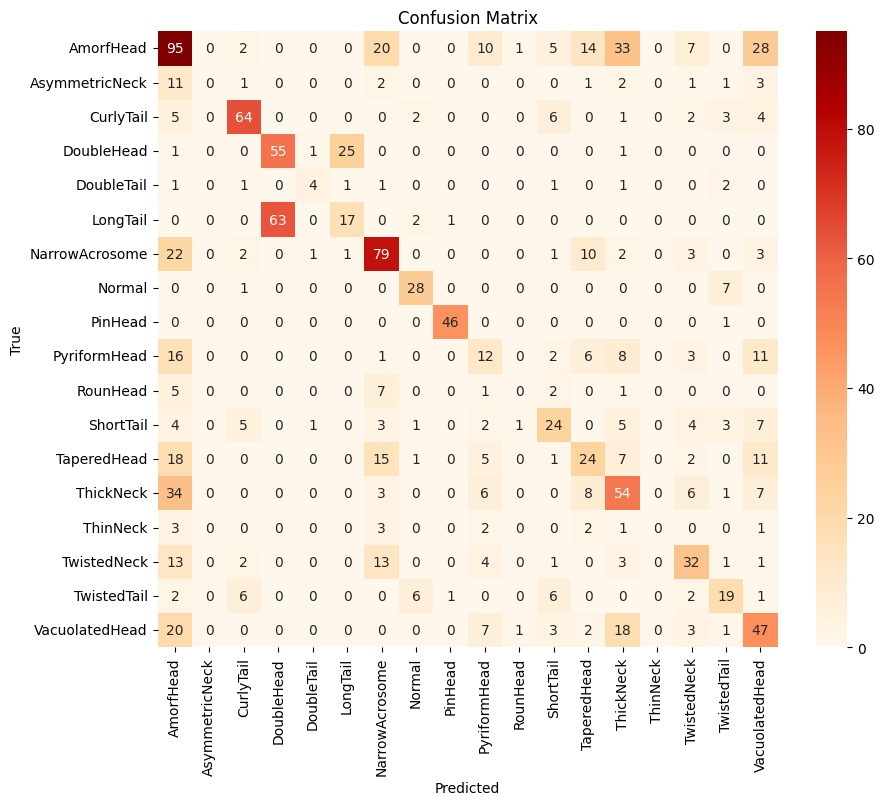

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import torch

# Put the model in evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Disable gradient calculations for inference
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader is DataLoader for validation data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max logit as prediction

        # Collect true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate the classification report
class_names = val_dataset.classes  # Assuming `val_dataset` has class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, cmap="OrRd", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [6]:
torch.save(model, "trained_model_main.pth")
print("Model saved as 'trained_model.pth'")

Model saved as 'trained_model.pth'
